# *Cross validation* I: Treinamento, Validação e Teste

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
- 2. [Carregando a base](#2)
- 3. [Base de Treinamento, Validação e Teste](#3)
- 4. [Cálculo dos CCP-alphas](#4)
- 5. [Obtendo a melhor árvore](#5)
- 6. [Avaliando a melhor árvore](#6)
- 7. [Gancho para a próxima aula](#7)


### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

O gancho da aula passada:

- Será que "demos sorte" de a base de testes ter esse desempenho?  
- Com outra base teriamos o mesmo desempenho?  
- Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?

Na aula passada, como a base de testes foi utilizada para 'tunar' o modelo, é razoável imaginarmos que ao aplicar o modelo a uma base mais ampla, não vamos obter exatamente esta acurácia.

Vamos fazer uma primeira tentativa de resolver este problema separando uma base de testes *holdout*, que não será utilizada nem no desenvolvimento do modelo, nem na escolha dos hiperparâmetros, e no final, vamos avaliar a qualidade do modelo nesta base.

In [5]:
import pandas            as pd 
import numpy             as np 
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split


### 2. Carregando a base<a name="2"></a>
[Voltar para o índice](#topo)

Nesta aula vamos carregar a base já tratada na aula passada, com os valores faltantes da variável ```sex``` preenchidos.

In [7]:
pg1 = pd.read_csv('pg1.csv')
pg1.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### 3 Bases de Treino, Validação e Teste<a name="3"></a>
[Voltar para o índice](#topo)

Vamos separar 20% da base para testes (*holdout*) e 20% da base para validação. Os restantes 60% vamos utilizar para a base de treino.

In [8]:
X = pd.get_dummies(pg1.drop(columns=['island','species']), drop_first=True)
y = pg1.species

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=1729)

### 4. Cálculo dos ```ccp_alphas```<a name="4"></a>
[Voltar para o índice](#topo)

Essa etapa é muito semelhante ao que já fizemos: vamos calcular os possíveis ```ccp_alpha```s de todas as possíveis podas da nossa árvore para em seguida fazer a avaliação dessas podas na base de testes.

In [9]:
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [10]:
ccp_alphas

array([0.        , 0.00922722, 0.00957049, 0.0140056 , 0.05017588,
       0.19969271, 0.33429547])

In [11]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

### 5. Obtendo a melhor árvore<a name="5"></a>
[Voltar para o índice](#topo)

Vamos fazer as avaliações das árvores obtidas na base de testes, e escolher o hiperparâmetro ```ccp_alpha``` que corresponder à melhor acurácia na base de validação.

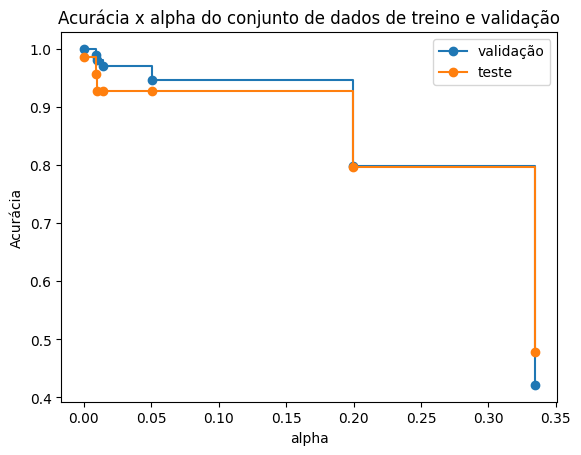

In [12]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [13]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 98.55


DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=2360873)

### 6. Avaliando a melhor árvore<a name="6"></a>
[Voltar para o índice](#topo)

Agora é a hora da verdade, vamos ver se essa acurácia se "sustenta" na base de testes.

Acurácia: 94.20


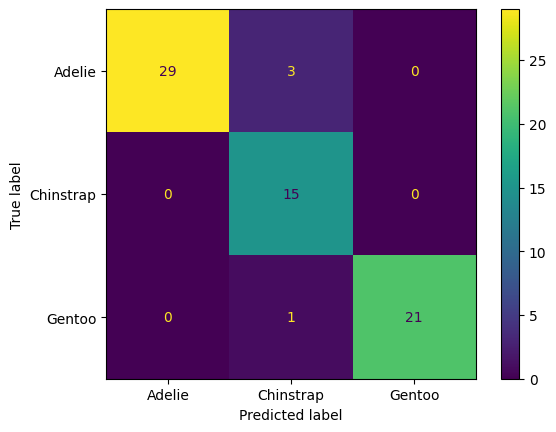

In [15]:
acuracia_teste = melhor_arvore.score(X_test, y_test)

print(f'Acurácia: {acuracia_teste*100:.2f}')

# Substituindo plot_confusion_matrix pela nova abordagem
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_test, y_test)

### 7. Gancho para a próxima aula:<a name="7"></a>
[Voltar para o índice](#topo)

- O que aconteceria se tivessemos pego outra base de testes?
- Será que essa base de testes não propicia casualmente uma acurácia maior ou menor?
- Já estamos 'perdendo' 20% da base para teste, perdemos outros 20% para validação, não podemos minimizar isso?